This assessment will take a look at a dataset of news articles from the BBC, found from the following source:

“BBC News Classification.” Kaggle, https://www.kaggle.com/competitions/learn-ai-bbc/data. 

After some exploratory data analysis, non-negative matrix factorization is used to identify top word components that are associated with each category cluster. Next, the NMF matricies are used to generate predictions of article types based on word frequencies. Finally, this method of prediction will be compared to other standard predictive algorithms. 

In [41]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import confusion_matrix

## EDA

The dataset consists of 1490 objects, each associated with an article ID, text consisting of title and body, and the category linked to that article. 

A quick look at the datatypes and counts indicate that there are zero null values and all text entries are objects, so no imputation will be required here.

In [2]:
df = pd.read_csv('BBC_News_Train.csv')
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


Assessing the counts of each category of the target variable indicates relatively balanced data. Paring of data to achieve balance will not be necessary here.

<AxesSubplot: >

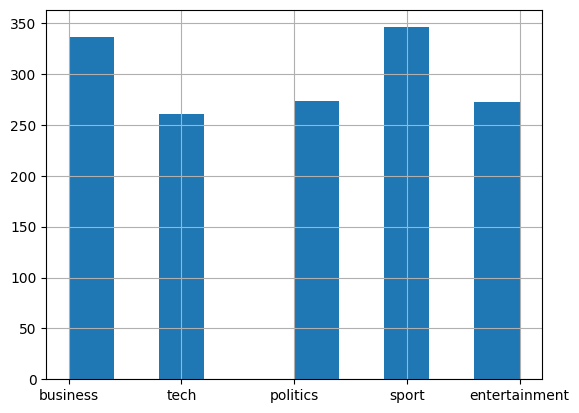

In [4]:
df.Category.hist()

It can be seen that the average word count is 414, with the word counts following a somewhat normal distribution with a fat right tail. Since there do not appear to be noticable sub-groupings based on word count, it will not be used as an attribute in generating models. 

Mean word count:  414.04295302013423


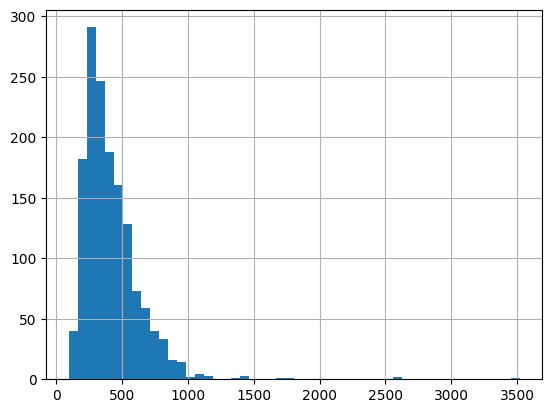

In [5]:
word_counts = df.Text.str.split(' ').str.len()
word_counts.hist(bins=50)
print('Mean word count: ', word_counts.mean())

## Vectorization

The text is vectorized to allow for processing by the models. This vectorization creates a matrix of all articles by all words in all articles, with word frequency per article listed at the intersection of each column and row. This gives an overall assessment of relative word weight per article. The sum the word frequencies associated with each article are normalized to be 1. 

After testing for performance, the following parameters were selected:

The default L2 normalization function is used. Both unigrams and bigrams (single words as well as two-word phrases) will be considered. Stop words are considered here. Additionally, the 5% of most common words will be filtered out. The 1% of least common words will also be filtered out to help prevent overfitting, as well as to keep the dataset at a reasonable size. Sublinear term frequency will be enabled as word counts follow a somewhat normal distribution as demonstrated above, and enabling this normalized these word counts by using their logs. 

In [6]:
# Takes a dataframe, returns a vectorized numpy matrix, associated dataframe, and vectorizer object.
def df_to_vect(dataframe, shuf=False):
    if shuf == True:
        dataframe = dataframe.sample(frac=1, random_state=0).reset_index(drop=True)
    
    vect = TfidfVectorizer(sublinear_tf=True, norm='l2', min_df=0.01, max_df=0.95, ngram_range=(1, 2), stop_words='english')
    vectX = vect.fit_transform(dataframe.Text)
    
    vectX = vectX.toarray()
    df_vect = pd.DataFrame(vectX, columns=vect.get_feature_names_out())
    df_vect['Category'] = dataframe.Category
    df_vect.insert(0, 'ArticleId', dataframe.ArticleId, True)
    
    return vectX, df_vect, vect

vectX, df_vect, vect = df_to_vect(df)

print(df_vect.shape)
df_vect.head()

(1490, 3224)


,ArticleId,000,000 jobs,000 people,000 year,10,10 000,10 years,100,100 000,...,years ago,yen,yes,york,young,young people,younger,yukos,zealand,Category
0,1833,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.076724,0.0,0.0,0.000000,0.0,0.0,business
1,154,0.000000,0.0,0.00000,0.0,0.051182,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,business
2,1101,0.040703,0.0,0.07226,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.065294,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,business
3,1976,0.035015,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.056170,0.0,0.0,0.000000,0.0,0.0,0.119458,0.0,0.0,tech
4,917,0.000000,0.0,0.00000,0.0,0.047420,0.0,0.0,0.0,0.0,...,0.071549,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,business


In [7]:
# Identifies the set of target labels. 
labels = df.Category.unique()
labels

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

## NMF Model: Training and Self-Prediction

Below, the NMF model is initialized to find 5 unique classes and fit using the vectorized data.

In [8]:
# Creation of the NMF model and matricies.
nmf_model = NMF(n_components=5, init='random', random_state=10)
W = nmf_model.fit_transform(vectX)
H = nmf_model.components_

A function built to determine the top n words per category. The categories as of now are unlabled, but it can be easily assumed which grouping belongs to which category. 

In [9]:
def max_impact_words(mat, word_names, num_words=5):
    for cat in mat:
        locs = cat.argsort()[-num_words:][::-1]
        print(word_names[locs])

words = vect.get_feature_names_out()     
max_impact_words(H, word_names=words)

['people' 'users' 'technology' 'mobile' 'software']
['game' 'win' 'england' 'cup' 'team']
['growth' 'said' 'market' 'year' 'economy']
['mr' 'labour' 'election' 'blair' 'party']
['film' 'best' 'awards' 'actor' 'award']


In [10]:
# Mapping of target lables to ordering.
ordered_labels = {0:'tech', 1:'sport', 2:'business', 3:'politics', 4:'entertainment'}

Now that the categories have been identified, a prediction function can be created to assess the accuracy of this method of labeling. The H matrix of the NMF matricies is multiplied with the transpose of a dataframe of vectorized values to predict. 

In [11]:
# Takes a vectorized dataframe of ArticleId and word frequencies and returns a dataframe of predictions for each entry.
def nmf_predict(H_mat, dataframe, labels):
    IDs = dataframe.ArticleId
    df_calc = dataframe.iloc[:, 1:]
    calcs = np.dot(H_mat, np.transpose(df_calc))
    best = calcs.argmax(axis=0)
    data = {'ArticleId': IDs, 'Category': best}
    preds = pd.DataFrame(data)
    preds = preds.replace({'Category':labels})
    return preds
    
preds = nmf_predict(H_mat = H, dataframe = df_vect.iloc[:, :-1], labels=ordered_labels)
preds

,ArticleId,Category
0,1833,business
1,154,business
2,1101,business
3,1976,tech
4,917,business
...,...,...
1485,857,entertainment
1486,325,tech
1487,1590,business
1488,1587,tech


A training accuracy of 93% was attained using this method.

In [12]:
# Train accuracy
vals = preds.Category == df.Category
vals.sum() / vals.count()

0.9275167785234899

In [46]:
confusion_matrix(preds.Category, df.Category)

array([[321,   7,  11,   2,   2],
       [  0, 217,   0,   2,   3],
       [  5,   2, 249,   1,   0],
       [  0,   5,   0, 341,   2],
       [ 10,  42,  14,   0, 254]], dtype=int64)

## NMF Model: Train/Test Split and Prediction

Now that the predictive method has been demonstrated on the train dataset, it is important to test the method on a train/test split in order to ensure that the model is not being overtrained. The following approach shuffles the initial dataset, splits it into 75% train, 25% test sets, and follows similar assessment methods as above. 

In [13]:
# Shuffling the dataset to break up any groupings.
vectX_TT, df_vect_TT, vect_TT = df_to_vect(df, shuf=True)


# Split the train and test into 2/3rds train, 1/3rd test.
n = len(df_vect_TT)
slice_idx = int(n*0.75)
vectX_train = vectX_TT[:slice_idx]
vectX_test = vectX_TT[slice_idx:]

df_vect_train = df_vect_TT.iloc[:slice_idx]
df_vect_test = df_vect_TT.iloc[slice_idx:]

df_vect_TT.head()

,ArticleId,000,000 jobs,000 people,000 year,10,10 000,10 years,100,100 000,...,years ago,yen,yes,york,young,young people,younger,yukos,zealand,Category
0,1866,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,entertainment
1,1349,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,politics
2,1572,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,sport
3,1155,0.03325,0.0,0.0,0.0,0.035350,0.0,0.0,0.047977,0.0,...,0.0,0.0,0.0,0.0,0.082478,0.06914,0.0,0.0,0.0,politics
4,307,0.00000,0.0,0.0,0.0,0.056829,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.186871,0.00000,0.0,0.0,0.0,sport


In [14]:
nmf_model2 = NMF(n_components=5, init='random', random_state=10)
W2 = nmf_model2.fit_transform(vectX_train)
H2 = nmf_model2.components_

In [15]:
# Finds the top words indicating each cluster. 
words_TT = vect.get_feature_names_out()     
max_impact_words(H2, word_names=words_TT)

['film' 'best' 'awards' 'actor' 'award']
['game' 'win' 'england' 'match' 'play']
['people' 'technology' 'mobile' 'users' 'phone']
['labour' 'mr' 'election' 'party' 'blair']
['said' 'growth' 'market' 'company' 'year']


In [16]:
# Updates the associated labels with the correct terms.
ordered_labels_TT = {0:'entertainment', 1:'sport', 2:'tech', 3:'politics', 4:'business'}

In [17]:
# Returns the predictions of the test set from the train/test split.
preds_TT = nmf_predict(H_mat = H2, dataframe = df_vect_test.iloc[:, :-1], labels=ordered_labels_TT)
preds_TT

,ArticleId,Category
1117,816,tech
1118,1797,entertainment
1119,1402,business
1120,1179,tech
1121,1750,sport
...,...,...
1485,268,business
1486,614,business
1487,85,entertainment
1488,817,business


In [18]:
# Test accuracy
vals_TT = preds_TT.Category == df_vect_test.Category
vals_TT.sum() / vals_TT.count()

0.9490616621983914

Above, it can be seen that a test accuracy of 95% was attained. 

## NMF Model: Prediction on Testing Dataset

This NMF pipeline will now be applied to the test dataset given in Kaggle. Though the true labels are not available for this set, the accuracy can be determined by submission to the Kaggle competition page.

In [19]:
df_S = pd.read_csv('BBC_News_Test.csv')
# Observing the size of the dataset and ensuring no null values.
df_S.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


Because this dataset when vectorzied will likely be comprised of at least some different words appearing, the vectorization function above will not be used. Rather, all the word frequencies will be obtained from the test dataset. These words will then be pared back if they do not exist in the train dataset. Next, words that do appear in the train dataset but not this test dataset will be added and padded with zeros. These steps will ensure that the test data has the same observed words before being fed into the prediction function.

In [20]:
vect_S = TfidfVectorizer(sublinear_tf=True, norm='l2', ngram_range=(1,2), stop_words='english')
vectX_S = vect_S.fit_transform(df_S.Text)

vectX_S = vectX_S.toarray()
df_vect_S = pd.DataFrame(vectX_S, columns=vect_S.get_feature_names_out())
df_vect_S.insert(0, 'ArticleId', df_S.ArticleId, True)

print(df_vect_S.shape)
df_vect_S.head()

(735, 143433)


,ArticleId,00,00 59,00 qualifying,000,000 000,000 12,000 131,000 133,000 15,...,zornotza amorebieta,zubair,zubair ahmed,zurich,zurich financial,zurich opera,zurich premiership,zurich reported,zvyagintsev,zvyagintsev return
0,1018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Drop all the test columns that do not exist in the train set.
target_columns = df_vect.columns[:-1]
df_vect_S.drop(columns=[col for col in df_vect_S if col not in target_columns], inplace=True)
df_vect_S.head()

,ArticleId,000,000 jobs,000 people,000 year,10,10 000,10 years,100,100 000,...,years,years ago,yen,yes,york,young,young people,younger,yukos,zealand
0,1018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.065085,0.0,0.0,0.0,0.000000,0.0,0.0
1,1319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.018969,0.035106,0.0,0.000000,0.0,0.0,0.0,0.041725,0.0,0.0
4,1020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [22]:
# Finds the column names that exist in the train dataset but not the test dataset. 
cols_to_add = [col for col in target_columns if col not in df_vect_S.columns]
cols_to_add

['rescue', 'stood']

In [23]:
# Add the necessary columns to the test dataset. 
for new_col in cols_to_add:
    data = [0.0] * len(df_vect_S)
    idx = df_vect.columns.get_loc(new_col)
    df_vect_S.insert(loc=idx, column = new_col, value = data, allow_duplicates=False)

In [24]:
# Checks to ensure column labels are identical, save for the label.
# If no output, the dataset columns are identical. 
col_checks = df_vect_S.columns == df_vect.columns[:-1]
for boo in col_checks:
    if boo == False:
        print('Fail')
        break

Below are the predictions for the test set.

In [26]:
preds_test = nmf_predict(H_mat = H, dataframe = df_vect_S, labels=ordered_labels)
preds_test.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


## Supervised Learning Approaches

Now that NMF has been used to identify keywords associated with text categories and predict those categories, other traditional supervised learning models will be employed for comparison. 

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import ComplementNB

In [40]:
X = df_vect.iloc[:, 1:-1]
y = df_vect.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

CNB = ComplementNB()
CNB.fit(X_train, y_train)

y_pred = CNB.predict(X_test)
accuracy_score(y_test, y_pred)

0.9765100671140939